In [ ]:
!pip install bertopic langdetect langid pyldavis PyPDF2 pdfplumber

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer

from transformers import pipeline
from transformers import AutoTokenizer
import transformers
import torch
import accelerate

from bertopic import BERTopic

from langdetect import detect
import langid

from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import re
import random
import os

import PyPDF2
import pdfplumber

from sentence_transformers import SentenceTransformer

import zipfile
import requests
import io

from umap import UMAP

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
barclays_q_and_a_file_id = "1d5uzYISPR67egf2MSqxzb5AJVsz9rmf5";

r = requests.get('https://drive.google.com/uc?export=download&id=%s' % (barclays_q_and_a_file_id), stream=True)
bytes_io = io.BytesIO(r.content)
zipf = zipfile.ZipFile(bytes_io)

pdf_texts = {}

for item in zipf.namelist():
  if item.endswith('.pdf'):
    f = zipf.open(item)
    identifier = item.split('-')[0]
    with pdfplumber.open(f) as pdf:
      pdf_text = ''.join([page.extract_text() for page in pdf.pages])
    pdf_texts[identifier] = pdf_text

print(pdf_texts.keys())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



dict_keys(['20190430', '20190807', '20191025', '20200213', '20200507', '20200731', '20201023', '20210218', '20210430', '20210728', '20211021', '20220223', '20220428', '20220728', '20221026', '20230215', '20230427', '202307xx', '202310xx', '202404xx', '202407xx'])


In [ ]:
def clean_text0(s):
  s = re.sub(r'^Investor Relations$', '', s, flags = re.MULTILINE)
  s = re.sub(r'^Barclays PLC Q[0-9]+ [0-9]{4} Results$', '', s, flags = re.MULTILINE)
  s = re.sub(r'^Barclays PLC H[0-9]+ [0-9]{4} Results$', '', s, flags = re.MULTILINE)
  s = re.sub(r'^Results call Q&A transcript \(amended in places to improve accuracy and readability\)$', '', s, flags = re.MULTILINE)
  s = re.sub(r'^[0-9]{2} [a-zA-Z]+ [0-9]{4}$', '', s, flags = re.MULTILINE)
  s = re.split(r'^[0-9]*Important Notice$', s, flags = re.MULTILINE)[0]
  # s = re.split(r'^[0-9]*Important Information$', s, flags = re.MULTILINE)[0]

  s = re.sub(r'[\'\"’]', '\'', s, flags = re.MULTILINE)

  s = re.sub(r'it\'s', 'it is', s, flags = re.MULTILINE)
  s = re.sub(r'\'s', '', s, flags = re.MULTILINE)
  s = re.sub(r'\'ve', ' have', s, flags = re.MULTILINE)
  s = re.sub(r'hasn\'t', 'has not', s, flags = re.MULTILINE)
  s = re.sub(r'don\'t', 'do not', s, flags = re.MULTILINE)
  s = re.sub(r'can\'t', 'can not', s, flags = re.MULTILINE)
  s = re.sub(r'won\'t', 'will not', s, flags = re.MULTILINE)
  s = re.sub(r'wouldn\'t', 'would not', s, flags = re.MULTILINE)
  s = re.sub(r'isn\'t', 'is not', s, flags = re.MULTILINE)
  s = re.sub(r'\'d', ' would', s, flags = re.MULTILINE)
  s = re.sub(r'\'ll', ' will', s, flags = re.MULTILINE)
  s = re.sub(r'\'re', ' are', s, flags = re.MULTILINE)
  s = re.sub(r'\'m', ' am', s, flags = re.MULTILINE)

  # s = re.sub(r'[^A-Za-z0-9\s]+', '', s, flags = re.MULTILINE);

  # s = s.lower();

  s = re.sub(r'\bquestion\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bquestions\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bthank\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bthanks\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bmeeting\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bbreakfast\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bcall\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\banna\b', '', s, flags = re.MULTILINE)

  s = re.sub(r'\bokay\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bthink\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bwould\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bcould\b', '', s, flags = re.MULTILINE)

  s = re.sub(r'\bus\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\buk\b', '', s, flags = re.MULTILINE)

  s = re.sub(r'\bmorning\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bhi\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bhello\b', '', s, flags = re.MULTILINE)

  return s

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
def extract_question_answer(s):
  # p = re.findall(r'^([A-Za-z\.]+ [A-Za-z]+(-[A-Za-z]+)?)(, [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?$', s, flags = re.MULTILINE)
  p = re.findall(r'^([A-Za-z\.]+ [A-Za-z]+(-[A-Za-z]+)?)((, [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?)$', s, flags = re.MULTILINE)
  # s = re.split(r'^[A-Za-z\.]+ [A-Za-z]+(-[A-Za-z]+)?(, [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?$', s, flags = re.MULTILINE)
  s = re.split(r'^([A-Za-z\.]+ [A-Za-z]+(-[A-Za-z]+)?)((, [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?)$', s, flags = re.MULTILINE)
  s = [line for line in s if line is not None]
  # s = [line for line in s if len(line.split(' ')) > 2]
  s = [line for line in s if (line.startswith('\n') and line.endswith('\n') and len(line.replace('\n', '')) > 0)]
  # p = [[pp[0], ''.join(pp[2:])] for pp in p]
  p = [[pp[0], pp[2]] for pp in p]
  full_s = s
  s = [re.sub(r'[^A-Za-z\s]+', '', ss, flags = re.MULTILINE) for ss in s]
  s = [re.sub(r'\n', ' ', ss, flags = re.MULTILINE) for ss in s]
  s = [ss.lower() for ss in s]

  stop_words = set(stopwords.words('english'))

  clean_s = []

  for ss in s:
    word_tokens = word_tokenize(ss)
    filtered = [w for w in word_tokens if not w in stop_words]
    filtered = [word for word in filtered if len(word) > 1]
    filtered = [word for word in filtered if word.find('bank') < 0]
    filtered = [word for word in filtered if word.find('banking') < 0]
    filtered = [word for word in filtered if word.find('uk') < 0]
    filtered = [word for word in filtered if word.find('barclays') < 0]
    filtered = [word for word in filtered if not word in ['yes', 'sorry', 'okay', 'hi', 'thank', 'thanks', 'much', 'got', 'hear', 'yeah', 'yup', 'yeap']]
    filtered = [word for word in filtered if not word in ['first', 'second', 'next', 'welcome', 'hello']]
    filtered = [word for word in filtered if not word in ['fair', 'lot', 'please', 'proceed', 'agree', 'disagree', 'guess', 'quick', 'followup', 'couple', 'fair', 'enough']]
    filtered = [word for word in filtered if not word in ['good', 'oh', 'sorry', 'repeat', 'appreciate', 'sure', 'awesome', 'excellent', 'understood', 'ahead', 'go', 'alright']]
    filtered = [word for word in filtered if not word in ['helpful', 'great', 'hey', 'follow', 'one', 'back', 'got', 'hear', 'yeah', 'right', 'hope']]
    filtered = [word for word in filtered if not word in ['care', 'today', 'fantastic', 'meetings', 'breakfast']]
    filtered = [word for word in filtered if not word in ['believe', 'lovely', 'adam', 'ok', 'oneoff', 'nature', 'nothing', 'magical', 'discuss', 'offline']]
    filtered = [word for word in filtered if not word in ['anna', 'board', 'typically', 'throughout', 'year', 'matter', 'yearend', 'saw', 'last', 'year', 'different', 'discussion', 'pr', 'keep', 'posted', 'give', 'timeline', 'analyst', 'everyone', 'really', 'summer', 'break', 'see', 'soon']]
    filtered = [word for word in filtered if not word in ['crystal', 'ball', 'jes', 'anything', 'else', 'want', 'say', 'everybody', 'look', 'forward', 'seeing', 'many', 'weeks', 'meantime', 'andy', 'chris', 'sellside', 'rest', 'day']]
    filtered = [word for word in filtered if not word in ['conclude', 'joining', 'week', 'chance', 'speak', 'road', 'colour', 'take', 'time', 'continued', 'cleverer', 'community', 'monthonmonth']]
    filtered = [word for word in filtered if not word in ['operator', 'concludes', 'wrap', 'hopefully', 'thereafter', 'venkat']]
    filtered = [word for word in filtered if not word in ['correct', 'assumption', 'fastmoving', 'picture']]
    filtered = [word for word in filtered if not word in ['mean', 'sort', 'kind', 'number', 'like', 'look', 'actually']]
    filtered = [word for word in filtered if not word in ['taking', 'comp', 'fingers', 'exactly', 'graseck', 'ltv', 'jump', 'matthew', 'oversimplifying', 'want']]
    filtered = [word for word in filtered if not word in ['andrew', 'lim', 'socit', 'gnrale', 'sa', 'hawaii', 'lake']]
    filtered = [word for word in filtered if not word in ['million', 'billion', 'i', 'ii', 'iii', 'iv']]
    filtered = [word for word in filtered if not word in ['bye', 'marks', 'end', 'conference', 'today', 'disconnect', 'joining', 'enjoy', 'rest', 'day', 'folks', 'everybody', 'talking']]
    filtered = [word for word in filtered if not word in ['answer', 'expected', 'going', 'give', 'wanted', 'give', 'answer', 'say', 'aware', 'nevertheless', 'quite', 'detailed', 'indiscernible', 'derek', 'nonperforming']]
    filtered = [word for word in filtered if not word in ['know', 'bit', 'requeue', 'perfect', 'little', 'see', 'let', 'possible', 'outcome', 'meaningful']]
    filtered = [word for word in filtered if not word in ['concludes', 'years', 'volcker', 'conclusion', 'tell', 'stand', 'morning', 'pointing', 'well', 'unlikely']]
    filtered = [word for word in filtered if not word in ['whatever', 'probably', 'muchthere', 'eighteen', 'different', 'things']]
    filtered = [word for word in filtered if not word in ['another', 'part', 'forgot', 'yet', 'details', 'make', 'point', 'important']]
    filtered = [word for word in filtered if not word in ['color', 'add', 'quarter', 'gosh', 'reggie', 'guys', 'maybe', 'clear']]
    filtered = [word for word in filtered if not word in ['happens', 'hit', 'changing', 'wait', 'way', 'simple', 'forward', 'either', 'dashboard', 'shocked']]
    filtered = [word for word in filtered if not word in ['win', 'still', 'ok', 'dont', 'wherever', 'isnt', 'lbo', 'mitate', 'messaging', 'okeydokey']]
    filtered = [word for word in filtered if not word in ['reason', 'imitate', 'pray', 'serendipity', 'standby', 'even', 'interesting', 'everything', 'indeed', 'technically']]
    filtered = [word for word in filtered if not word in ['models', 'expecting', 'tidy', 'hop', 'issue', 'catch', 'nerd', 'distracted', 'queue', 'sufficient']]
    filtered = [word for word in filtered if not word in ['weights', 'changer', 'fun', 'sound', 'simplify', 'resolved', 'imminent', 'reading', 'rd', 'qs']]
    filtered = [word for word in filtered if not word in ['year', 'said', 'writedown', 'noticing', 'party', 'lastly', 'camp', 'intent', 'modestly', 'listen']]
    filtered = [word for word in filtered if not word in ['flip', 'last', 'time', 'wasnt', 'obviously', 'series', 'accordingly', 'emphasize', 'opinion', 'ready']]
    clean_s.append(' '.join(filtered))

  return p, clean_s, full_s

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
pdf_q_and_a = {}
for pdf_key, pdf_text in pdf_texts.items():
  s = clean_text0(pdf_texts[pdf_key])
  p, s, full_s = extract_question_answer(s)
  pdf_q_and_a[pdf_key] = [p, s, full_s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df_q_and_as = pd.DataFrame(columns=['Quarter', 'PersonQ', 'AffiliationQ', 'PersonA', 'AffiliationA', 'TextQ', 'TextA', 'FullTextQ', 'FullTextA'])

for pdf_key, q_and_a in pdf_q_and_a.items():
  p, s, full_s = q_and_a
  p_answering = []
  for i in range(len(p)):
    person = p[i][0].replace(', ', '') if len(p[i][0]) > 0 else ''
    affiliation = p[i][1].replace(', ', '') if len(p[i][1]) > 0 else ''
    person = person.lower()
    affiliation = affiliation.lower()
    if affiliation.startswith('group') or person in ['anna cross', 'c.s. venkatakrishnan']:
      p_answering.append(person)
  # print(set(p_answering))
  for i in range(int(np.min([len(s), len(p)]))):
    person = p[i][0].replace(', ', '')
    affiliation = p[i][1].replace(', ', '')
    person = person.lower()
    # print(pdf_key, person, set(p_answering), person not in p_answering)
    q_or_a = person not in p_answering
    text = s[i]
    text = text.split(' ')
    token_count = 50
    text = [' '.join(text[i:i + token_count]) for i in range(0, len(text), token_count)]
    text = [line for line in text if len(line) > 0]
    full_text = full_s[i]
    full_text = full_text.split(' ')
    token_count = 50
    full_text = [' '.join(full_text[i:i + token_count]) for i in range(0, len(full_text), token_count)]
    full_text = [line for line in full_text if len(line) > 0]
    if q_or_a:
      df_q_and_as.loc[df_q_and_as.shape[0]] = [pdf_key, person, affiliation, '', '', text, '', full_text, '']
    else:
      iloc_q = df_q_and_as.shape[0]-1
      df_q_and_as.loc[iloc_q].PersonA = person
      df_q_and_as.loc[iloc_q].AffiliationA = affiliation
      text_a = df_q_and_as.iloc[iloc_q].TextA
      full_text_a = df_q_and_as.iloc[iloc_q].FullTextA
      text.extend(text_a)
      full_text.extend(full_text_a)
      df_q_and_as.loc[iloc_q].TextA = text
      df_q_and_as.loc[iloc_q].FullTextA = full_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df_q_and_as

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Quarter               PersonQ          AffiliationQ  \
0    20190430      joseph dickerson             Jefferies   
1    20190430       jonathan pierce                 Numis   
2    20190430       jonathan pierce                 Numis   
3    20190430            robin down                  HSBC   
4    20190430         guy stebbings     Exane BNP Paribas   
5    20190430              ed firth                   KBW   
6    20190430        martin leitgeb         Goldman Sachs   
7    20190430            chris cant            Autonomous   
8    20190430            chris cant            Autonomous   
9    20190430          robert noble                   RBC   
10   20190430         andrew coombs                  Citi   
11   20190807        alvaro serrano        Morgan Stanley   
12   20190807       jonathan pierce                         
13   20190807         joe dickerson             Jefferies   
14   20190807            chris cant            Autonomous   
15   20190807        martin leitgeb         Goldman Sachs   
16   20190807         guy stebbings                 Exane   
17   20190807         guy stebbings                 Exane   
18   20190807         andrew coombs                  Citi   
19   20190807         andrew coombs                  Citi   
20   20190807         andrew coombs                  Citi   
21   20190807            robin down                  HSBC   
22   20190807          edward firth                   KBW   
23   20190807          edward firth                   KBW   
24   20190807          edward firth                   KBW   
25   20191025        alvaro serrano        Morgan Stanley   
26   20191025       jonathan pierce                 Numis   
27   20191025       jonathan pierce                 Numis   
28   20191025      joseph dickerson             Jefferies   
29   20191025      joseph dickerson             Jefferies   
30   20191025              ed firth                   KBW   
31   20191025              ed firth                   KBW   
32   20191025            robin down                  HSBC   
33   20191025        martin leitgeb         Goldman Sachs   
34   20191025         guy stebbings           BNP Paribas   
35   20191025         guy stebbings           BNP Paribas   
36   20191025          fahed kunwar               Redburn   
37   20191025          fahed kunwar               Redburn   
38   20191025            chris cant            Autonomous   
39   20191025            chris cant            Autonomous   
40   20191025          anke reinken   RBC Capital Markets   
41   20200213        alvaro serrano        Morgan Stanley   
42   20200213       jonathan pierce                 Numis   
43   20200213           claire kane         Credit Suisse   
44   20200213           claire kane         Credit Suisse   
45   20200213      joseph dickerson             Jefferies   
46   20200213         andrew coombs                  Citi   
47   20200213            chris cant            Autonomous   
48   20200213            robin down                  HSBC   
49   20200213         guy stebbings     Exane BNP Paribas   
50   20200213         guy stebbings     Exane BNP Paribas   
51   20200213            raul sinha             JP Morgan   
52   20200213              ed firth                   KBW   
53   20200213              ed firth                   KBW   
54   20200213              ed firth                   KBW   
55   20200213          fahed kunwar               Redburn   
56   20200213          fahed kunwar               Redburn   
57   20200213          fahed kunwar               Redburn   
58   20200213          fahed kunwar               Redburn   
59   20200507        alvaro serrano        Morgan Stanley   
60   20200507       jonathan pierce                 Numis   
61   20200507       jonathan pierce                 Numis   
62   20200507      joseph dickerson             Jefferies   
63   20200507  rohith chandra-rajan       Bank of America   
64   20200507  rohith chandra-rajan      

In [ ]:
umap = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=13)

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=sentence_model, umap_model=umap)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df_q_and_as.Quarter.unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array(['20190430', '20190807', '20191025', '20200213', '20200507',
       '20200731', '20201023', '20210218', '20210430', '20210728',
       '20211021', '20220223', '20220428', '20220728', '20221026',
       '20230215', '20230427', '202307xx', '202310xx', '202404xx',
       '202407xx'], dtype=object)

In [ ]:
# [(df_q_and_as.Quarter == '20200731') | (df_q_and_as.Quarter == '20200507')]

text_q = df_q_and_as.TextQ.values
text_a = df_q_and_as.TextA.values

text_q = [line for list_of_lines in text_q for line in list_of_lines]
text_a = [line for list_of_lines in text_a for line in list_of_lines]

text = text_q
text.extend(text_a)

topic_model.fit(text)
topic, probabilities = topic_model.transform(text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
topic_model.merge_topics(text, [[-1, 10]])
topic, probabilities = topic_model.transform(text)

topic_info = topic_model.get_topic_info()
topic_info.to_csv('Barclays_topics.csv', index=False)
topic_info

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic  Count                                             Name  \
0      -1    666                  -1_business_expect_terms_around   
1       0     70                          0_costs_cost_bn_actions   
2       1     58                   1_hedge_structural_yield_rates   
3       2     55              2_markets_business_market_financing   
4       3     45         3_capital_shareholders_dividend_buybacks   
5       4     36                     4_cib_revenues_revenue_costs   
6       5     36                         5_cards_card_business_us   
7       6     34                      6_balances_cards_card_spend   
8       7     33               7_deposit_deposits_pricing_savings   
9       8     31                        8_rwas_pillar_rwa_capital   
10      9     30                      9_nim_bps_guidance_headwind   
11     10     26              10_bn_transitional_stage_provisions   
12     11     24                 11_branches_brexit_branch_europe   
13     12     22             12_impairment_economic_run_forecasts   
14     13     22                           13_debt_income_grow_us   
15     14     19  14_compensation_variable_profitability_accruals   
16     15     18          15_restructuring_rote_charges_extensive   
17     16     17           16_cost_profitability_profitable_share   
18     17     16                      17_credit_benign_start_risk   
19     18     16                  18_book_mortgages_loan_mortgage   
20     19     16          19_refinancing_mortgage_spreads_precise   
21     20     15          20_payments_merchant_acquiring_business   
22     21     14            21_mda_procyclicality_headroom_buffer   
23     22     11                   22_fx_scale_interchange_staley   

                                                                                                     Representation  \
0                                        [business, expect, terms, around, nim, income, rates, rate, credit, given]   
1                                    [costs, cost, bn, actions, investment, efficiency, income, real, estate, base]   
2                                           [hedge, structural, yield, rates, rate, roll, expect, zero, month, nim]   
3                          [markets, business, market, financing, share, capital, volatility, cib, continue, prime]   
4   [capital, shareholders, dividend, buybacks, return, buyback, distribution, distributions, returning, dividends]   
5                              [cib, revenues, revenue, costs, cost, performance, transaction, terms, income, past]   
6                                           [cards, card, business, us, new, apple, portfolio, brand, growth, risk]   
7                                    [balances, cards, card, spend, us, credit, travel, wondering, share, spending]   
8                    [deposit, deposits, pricing, savings, migration, rates, competition, customers, within, peers]   
9                                  [rwas, pillar, rwa, capital, risk, riskweighted, assets, operational, ib, level]   
10                                      [nim, bps, guidance, headwind, rates, rate, pass, range, interest, margins]   
11                              [bn, transitional, stage, provisions, relief, two, ifrs, release, risk, programmes]   
12                [branches, brexit, branch, europe, customers, businesses, every, business, corporates, consumers]   
13                      [impairment, economic, run, forecasts, charge, lower, bn, impairments, underlying, credits]   
14                                        [debt, income, grow, us, movement, balances, portfolio, low, line, spend]   
15         [compensation, variable, profitability, accruals, performance, cib, accrual, revenues, accruing, return]   
16                       [restructuring, rote, charges, extensive, seem, cost, controls, expenses, target, capital]   
17                        [cost, profitability, profitable, share, costs, etns, business, revenue, market, healthy]   
18               

In [ ]:
topic_model.visualize_barchart(top_n_topics=32).show(renderer="colab")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(text)

hierarchical_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 22/22 [00:00<00:00, 134.33it/s]


Parent_ID                                    Parent_Name  \
21        44              capital_business_costs_terms_cost   
20        43                capital_business_costs_cib_cost   
19        42                business_costs_cib_cost_markets   
18        41                cib_costs_cost_business_markets   
17        40        capital_bn_shareholders_impairment_rwas   
16        39     business_branches_payments_europe_merchant   
15        38      capital_shareholders_rwas_dividend_return   
14        37                  cards_card_credit_balances_us   
13        36     branches_business_payments_europe_merchant   
12        35                 cib_costs_cost_markets_revenue   
11        34  capital_shareholders_dividend_return_buybacks   
10        33        impairment_bn_economic_transitional_run   
9         32               hedge_deposits_deposit_rates_nim   
8         31         rwas_pillar_rwa_capital_procyclicality   
7         30              credit_book_mortgages_risk_benign   
6         29                 costs_cib_cost_markets_revenue   
5         28               hedge_deposits_deposit_rates_nim   
4         27        markets_business_share_market_financing   
3         26                cards_card_us_balances_business   
2         25                cards_card_us_balances_business   
1         24                 hedge_nim_structural_bps_yield   
0         23                costs_cost_cib_revenue_revenues   

                                                                                Topics  \
21  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]   
20               [0, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22]   
19                                     [0, 2, 4, 5, 6, 11, 13, 14, 16, 17, 18, 20, 22]   
18                                                       [0, 2, 4, 11, 14, 16, 20, 22]   
17                                                              [3, 8, 10, 12, 15, 21]   
16                                                                        [11, 20, 22]   
15                                                                      [3, 8, 15, 21]   
14                                                                  [5, 6, 13, 17, 18]   
13                                                                            [11, 20]   
12                                                                   [0, 2, 4, 14, 16]   
11                                                                             [3, 15]   
10                                                                            [10, 12]   
9                                                                        [1, 7, 9, 19]   
8                                                                              [8, 21]   
7                                                                             [17, 18]   
6                                                                        [0, 2, 4, 16]   
5                                                                            [1, 7, 9]   
4                                                                              [2, 16]   
3                                                                           [5, 6, 13]   
2                                                                               [5, 6]   
1                                                                               [1, 9]   
0                                                                               [0, 4]   

   Child_Left_ID                                           Child_Left_Name  \
21            32                          hedge_deposits_deposit_rates_nim   
20            42                           business_costs_cib_cost_markets   
19            41                           cib_costs_cost_business_markets   
18            35                            cib_costs_cost_markets_revenue   
17            33                   impairment_bn_economic_transitional_run   
16            

In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, color_threshold=0.875, width=1600, height=1000, title='Barclays Q&A topic groups').show(renderer="colab")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

picked_topic_cluster_names = ['hedge_deposits_deposit_rates_nim', 'cib_costs_cost_markets_revenue', 'business_branches_payments_europe_merchant', 'cards_card_credit_balances_us', 'impairment_bn_economic_transitional_run', 'capital_shareholders_rwas_dividend_return']

picked_topic_cluster_ids = [hierarchical_topics[hierarchical_topics['Parent_Name'] == picked_topic_cluster_name].Parent_ID.values[0] for picked_topic_cluster_name in picked_topic_cluster_names]

picked_topic_cluster_keywords = [topic_info[topic_info['Topic'].isin(hierarchical_topics[hierarchical_topics['Parent_ID'] == picked_topic_cluster_id].Topics.values[0])].Representation.values for picked_topic_cluster_id in picked_topic_cluster_ids]

picked_topic_ids = [topic_info[topic_info['Topic'].isin(hierarchical_topics[hierarchical_topics['Parent_ID'] == picked_topic_cluster_id].Topics.values[0])].Topic.values for picked_topic_cluster_id in picked_topic_cluster_ids]

picked_topic_clusters = pd.DataFrame(columns=['Cluster_ID', 'Topic_cluster_name', 'Topics', 'Keywords'])

for i in range(len(picked_topic_cluster_names)):
  picked_topic_clusters.loc[picked_topic_clusters.shape[0]] = [picked_topic_cluster_ids[i], picked_topic_cluster_names[i], picked_topic_ids[i], picked_topic_cluster_keywords[i]]

picked_topic_clusters

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Cluster_ID                          Topic_cluster_name              Topics  \
0         32            hedge_deposits_deposit_rates_nim       [1, 7, 9, 19]   
1         35              cib_costs_cost_markets_revenue   [0, 2, 4, 14, 16]   
2         39  business_branches_payments_europe_merchant        [11, 20, 22]   
3         37               cards_card_credit_balances_us  [5, 6, 13, 17, 18]   
4         33     impairment_bn_economic_transitional_run            [10, 12]   
5         38   capital_shareholders_rwas_dividend_return      [3, 8, 15, 21]   

                                            Keywords  
0  [[hedge, structural, yield, rates, rate, roll,...  
1  [[costs, cost, bn, actions, investment, effici...  
2  [[branches, brexit, branch, europe, customers,...  
3  [[cards, card, business, us, new, apple, portf...  
4  [[bn, transitional, stage, provisions, relief,...  
5  [[capital, shareholders, dividend, buybacks, r...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
text_q = df_q_and_as.TextQ.values
text_a = df_q_and_as.TextA.values

# topic_info = [' '.join([topic_info[topic_info.Topic == topic_i].Name.values[0], str(topic_info[topic_info.Topic == topic_i].Representation.values[0])]) for topic_i in topic]
topic_info_list = [topic_info[topic_info.Topic == topic_i].Name.values[0] for topic_i in topic]

topic_info_per_q = []
topic_info_per_a = []

last_topic_i = 0
for i in range(len(text_q)):
  info_per_q = topic_info_list[last_topic_i:last_topic_i+len(text_q[i])]
  topic_info_per_q.append(info_per_q)
  last_topic_i = last_topic_i+len(text_q[i])

# last_topic_i = 0
for i in range(len(text_a)):
  info_per_a = topic_info_list[last_topic_i:last_topic_i+len(text_a[i])]
  topic_info_per_a.append(info_per_a)
  last_topic_i = last_topic_i+len(text_a[i])

topic_info_per_q = [list(set(topic_list)) for topic_list in topic_info_per_q]
df_q_and_as['TopicQ'] = topic_info_per_q

topic_info_per_a = [list(set(topic_list)) for topic_list in topic_info_per_a]
df_q_and_as['TopicA'] = topic_info_per_a

df_q_and_as = df_q_and_as.sort_values(by=['Quarter'])

df_q_and_as.to_csv('Barclays_q_and_a_with_topics.csv', index=False)

# df_q_and_as

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df_q_and_as_topic_special = df_q_and_as[['11_branches_brexit_branch_europe' in topic for topic in df_q_and_as['TopicQ'].values]]
df_q_and_as_topic_special[['FullTextQ', 'FullTextA']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



FullTextQ  \
16                                                                                                                                                                                                                                                                                                                                                                                                                       [\nSo the first  on Brexit, vis-à-vis the bank position, we began working right after the referendum\nvote to get the bank structured in such a way that we  deal with any possible outcome of Brexit.\nAnd what that really meant for  was changing the scope and scale of our, bank subsidiary in Dublin. It\nlooks likely to become, by the end of this year, the largest bank in Ireland. We then went through the\nprocess of every branch of the bank across Europe, from Frankfurt to Madrid to Paris, to relicense those\nbranches as branches of the bank in Ireland. We built, all the control systems necessary. We moved the\nnecessary people. And then, over the last couple of months, we have gone through the client migration\nprocess. We have left it up to the clients if they wanted to migrate from one platform to another, which has\ngone quite well. From the bank operational, point of view, even if we had a very hard Brexit at the end of\nOctober, the bank is totally prepared for it, and it  be really business as usual.\n4In terms of what we are seeing over the last couple of month vis-à-vis clients and customers, as Tushar\nalluded to, I,  people are modestly being more conservative. Our cash levels are up. Demand for credit\non the margin is lighter. On the institutional side, or the major corporate side, I  it is fair to say that\nsome of the big decisions, whether they were M&A decisions or investment decisions, have been, lighter\nthan one might expect.\nI  the big thing is, as we get closer to October 31st and there a real possibility of a no-deal hard\nBrexit, we want to be very mindful. We want to be very constructive in terms of helping small businesses\nin particular to  about cash flow levels,, etc., and we want to be committed to being a partner, to get\nthe UK economy through that event. But I  we are prepared. Going back to the opening comments\n– two years ago, we looked at our unsecured credit card portfolio and really tightened our underwriting\nconditions since then, which hopefully, has put the bank in a pretty prudent position as we go into the\nlatter part of this year.\nVis-à-vis the equities business, we do believe it is important to look at the profitability of the Markets\nbusiness overall. There will be some aspects of your Markets business which are less profitable than, others,\nbut there is a connectivity between the two of them. We are committed to our position in the US and in\nthe European capital markets across the equities platform. We have a very strong business in equities\nprime financing. We have a strong business in equities flow derivatives. We are going to, stay committed,\nboth on the research side and on the execution side, to equities.\n]   
12                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  [\nIn terms of gilt gains, I am not sure how far you have got through our disclosures, but you will see in the notes\nthat we have split out how much of the revaluation of our AFS reserve has been recycled to P&L in the\nnormal course of business, as we recycle, our liquidity pool positions. It actually slightly lower in H119\nthan H118 on an after-tax basis. I  it was a little less than

In [ ]:
topic_info = topic_model.get_topic_info()

topics_per_q = pd.DataFrame(index=df_q_and_as.Quarter.unique(), columns=topic_info.Name.unique())
column_names = dict(zip(topic_info.Name.unique(), [topic.split('_')[0] for topic in topic_info.Name.unique()]))

for index, row in df_q_and_as.iterrows():
  topics_row_a = row.TopicA
  topics_row_q = row.TopicQ
  for topic_row_a in topics_row_a:
    topics_per_q.at[row.Quarter, topic_row_a] = topics_per_q.at[row.Quarter, topic_row_a] + 1 if not np.isnan(topics_per_q.at[row.Quarter, topic_row_a]) else 1

topics_per_q.rename(columns=column_names, inplace=True)

topics_per_q['Quarter'] = df_q_and_as.Quarter.unique()

topics_per_q.replace(np.nan, 0, inplace=True)

topics_per_q.drop(columns=[topics_per_q.columns[0]], inplace=True)

topics_per_q.to_csv('Barclays_topics_per_quarter.csv', index=True)

topics_per_q

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  \
20190430  2  0  0  0  1  3  0  0  1  0   1   0   0   0   0   0   1   1   0   
20190807  2  1  1  3  0  0  1  0  1  0   0   2   0   0   0   0   0   0   0   
20191025  1  1  2  1  1  1  0  1  1  0   0   1   1   1   1   0   1   0   2   
20200213  3  0  2  0  0  1  0  0  1  2   0   2   0   3   0   0   1   0   1   
20200507  2  0  2  0  0  1  1  0  2  0   4   0   2   1   0   0   0   1   1   
20200731  1  0  1  0  2  0  1  0  2  1   0   3   2   2   1   0   1   0   0   
20201023  1  1  0  0  1  2  0  0  0  1   0   2   1   0   1   1   2   3   0   
20210218  3  0  2  1  3  1  4  0  0  0   0   0   2   1   0   0   1   1   1   
20210430  3  2  2  0  1  3  0  0  0  0   1   2   1   1   4   0   1   0   0   
20210728  6  0  1  2  0  1  3  0  0  2   1   0   0   2   2   2   1   1   0   
20211021  4  0  4  3  1  1  0  0  1  1   1   0   0   0   1   0   0   1   0   
20220223  1  0  4  1  1  1  1  1  0  1   0   0   0   0   0   0   1   0   0   
20220428  1  0  1  0  0  2  2  0  0  1   0   0   0   0   0   0   1   0   0   
20220728  2  4  2  1  0  1  1  0  0  1   0   0   1   1   0   1   0   1   0   
20221026  1  4  2  0  0  0  1  0  2  1   4   0   1   1   0   0   0   0   3   
20230215  1  3  2  1  1  0  1  2  2  1   0   0   0   0   0   1   1   0   0   
20230427  1  1  1  2  1  1  0  0  0  1   0   0   1   0   0   0   0   0   0   
202307xx  1  3  2  1  3  1  0  1  0  1   0   0   0   1   0   0   0   0   0   
202310xx  1  3  0  3  0  0  0  5  0  1   1   0   1   1   0   1   0   0   0   
202404xx  0  2  0  1  0  0  0  2  0  0   0   1   0   1   1   0   0   0   0   
202407xx  0  0  0  1  0  0  1  2  2  0   0   0   0   0   0   0   0   0   0   

          19  20  21  22   Quarter  
20190430   0   1   0   0  20190430  
20190807   1   1   0   0  20190807  
20191025   1   1   0   1  20191025  
20200213   0   2   1   0  20200213  
20200507   0   0   1   0  20200507  
20200731   0   0   2   0  20200731  
20201023   1   0   0   0  20201023  
20210218   0   0   2   0  20210218  
20210430   0   1   0   1  20210430  
20210728   0   0   0   0  20210728  
20211021   1   1   0   0  20211021  
20220223   1   1   1   0  20220223  
20220428   0   0   0   1  20220428  
20220728   1   1   0   1  20220728  
20221026   1   0   0   0  20221026  
20230215   1   0   0   0  20230215  
20230427   1   0   0   0  20230427  
202307xx   2   0   0   0  202307xx  
202310xx   0   1   0   0  202310xx  
202404xx   1   0   0   0  202404xx  
202407xx   0   0   1   0  202407xx

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



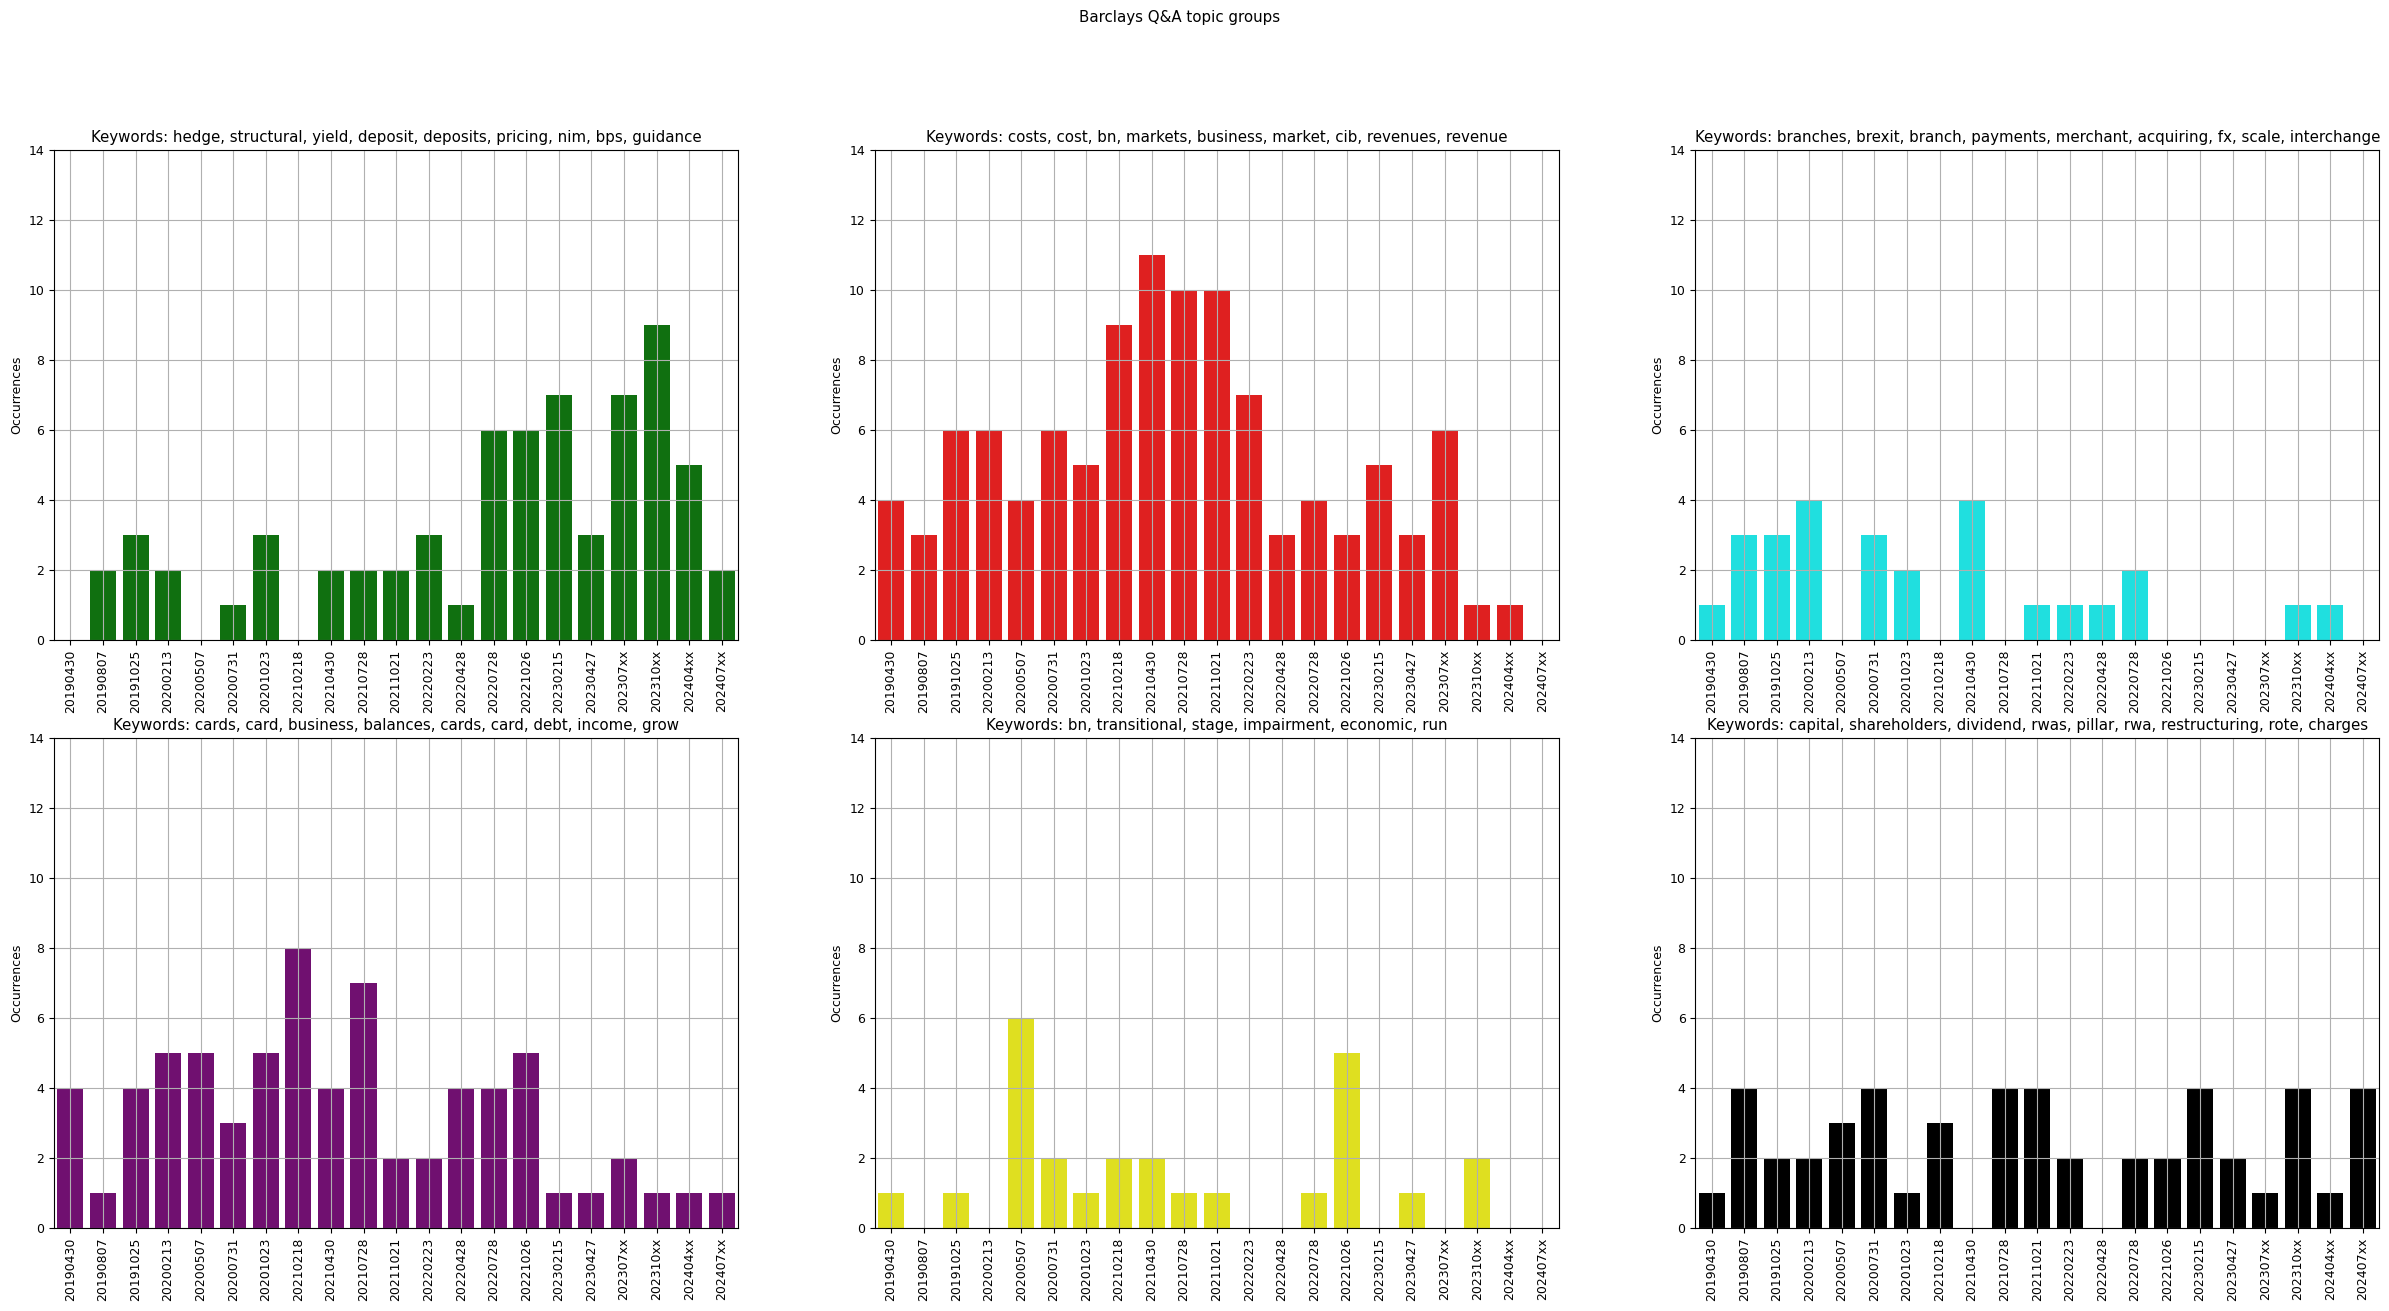

In [ ]:
topic_clusters = []
for cluster_id in picked_topic_cluster_ids:
  topic_clusters.append([hierarchical_topics[hierarchical_topics['Parent_ID'] == cluster_id].Topics.values[0]])

plt.figure(figsize=(30, 14))
plt.rcParams.update({'font.size': 9})
colors = ['green', 'red', 'cyan', 'purple', 'yellow', 'black']

# print(picked_topic_cluster_keywords)
topic_keywords = [', '.join([', '.join(topic_keyword[0:3]) for topic_keyword in topic_keywords[0:3]]) for topic_keywords in picked_topic_cluster_keywords]

p = 1
num_rows = 2
for i in range(len(topic_clusters)):

  topic_cluster = [str(topic_id) for topic_id in topic_clusters[i][0]]
  # print(topic_cluster)
  values = topics_per_q[topic_cluster].sum(axis=1)

  plt.subplot(num_rows,int(np.ceil(len(topic_clusters)/num_rows)),p)
  sns.barplot(x="Quarter", y=values, data=topics_per_q, color=colors[(p-1)%len(colors)])
  plt.title('Keywords: ' + topic_keywords[i])
  plt.xticks(rotation=90)
  plt.ylabel("Occurrences")
  plt.xlabel("")
  plt.grid()
  plt.ylim([0, 14])
  p = p + 1

plt.suptitle('Barclays Q&A topic groups')
plt.show()